In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import brentq
from astroquery.gaia import Gaia

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Calculation: $r_\mathrm{max}$ versus $M_G$ for an ideal planet

In [3]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

# function to calculate sigma_fov as a function of distance and absolute G-band mag
def calc_sigma_fov(d, absGmag):
    appGmag = absGmag + 5.0*np.log10(d/10.0)
    
    # list/numpy array
    if type(appGmag) == list or type(appGmag) == np.ndarray:
        sigma_fovs = piecewise(appGmag, 53.89888779)
        return sigma_fovs
    
    # float
    return piecewise(np.array([appGmag]), 53.89888779)[0]

In [4]:
# function to calculate absolute G-band magnitude from stellar mass
def calc_absGmag(mass, coeff=np.array([16.91206805,  24.95258266,   4.0433877 , -13.63108438, 4.77092427])):
    return np.polyval(coeff, np.log10(mass))

In [5]:
# function whose root is the limiting distance 
def root_function(d, absGmag, mratio, a, N_sigma):
    return d * calc_sigma_fov(d, absGmag) - 1e6*mratio*a/N_sigma

# function to calculate limiting distance (absGmag, mratio, and a are assumed to be floats)
def calc_limiting_distance(absGmag, mratio, a, N_sigma, d_min=1e-10, d_max=1e10, tol=1e-8):
    if root_function(d_min, absGmag, mratio, a, N_sigma) * root_function(d_max, absGmag, mratio, a, N_sigma) > 0:
        raise ValueError("The root is not bracketed in the given interval. Try adjusting d_min and d_max.")
            
    return brentq(root_function, d_min, d_max, args=(absGmag, mratio, a, N_sigma), xtol=tol)

coeffs1: [-0.06894517  3.40605655]
coeffs2: [0.09306298 2.95201128]


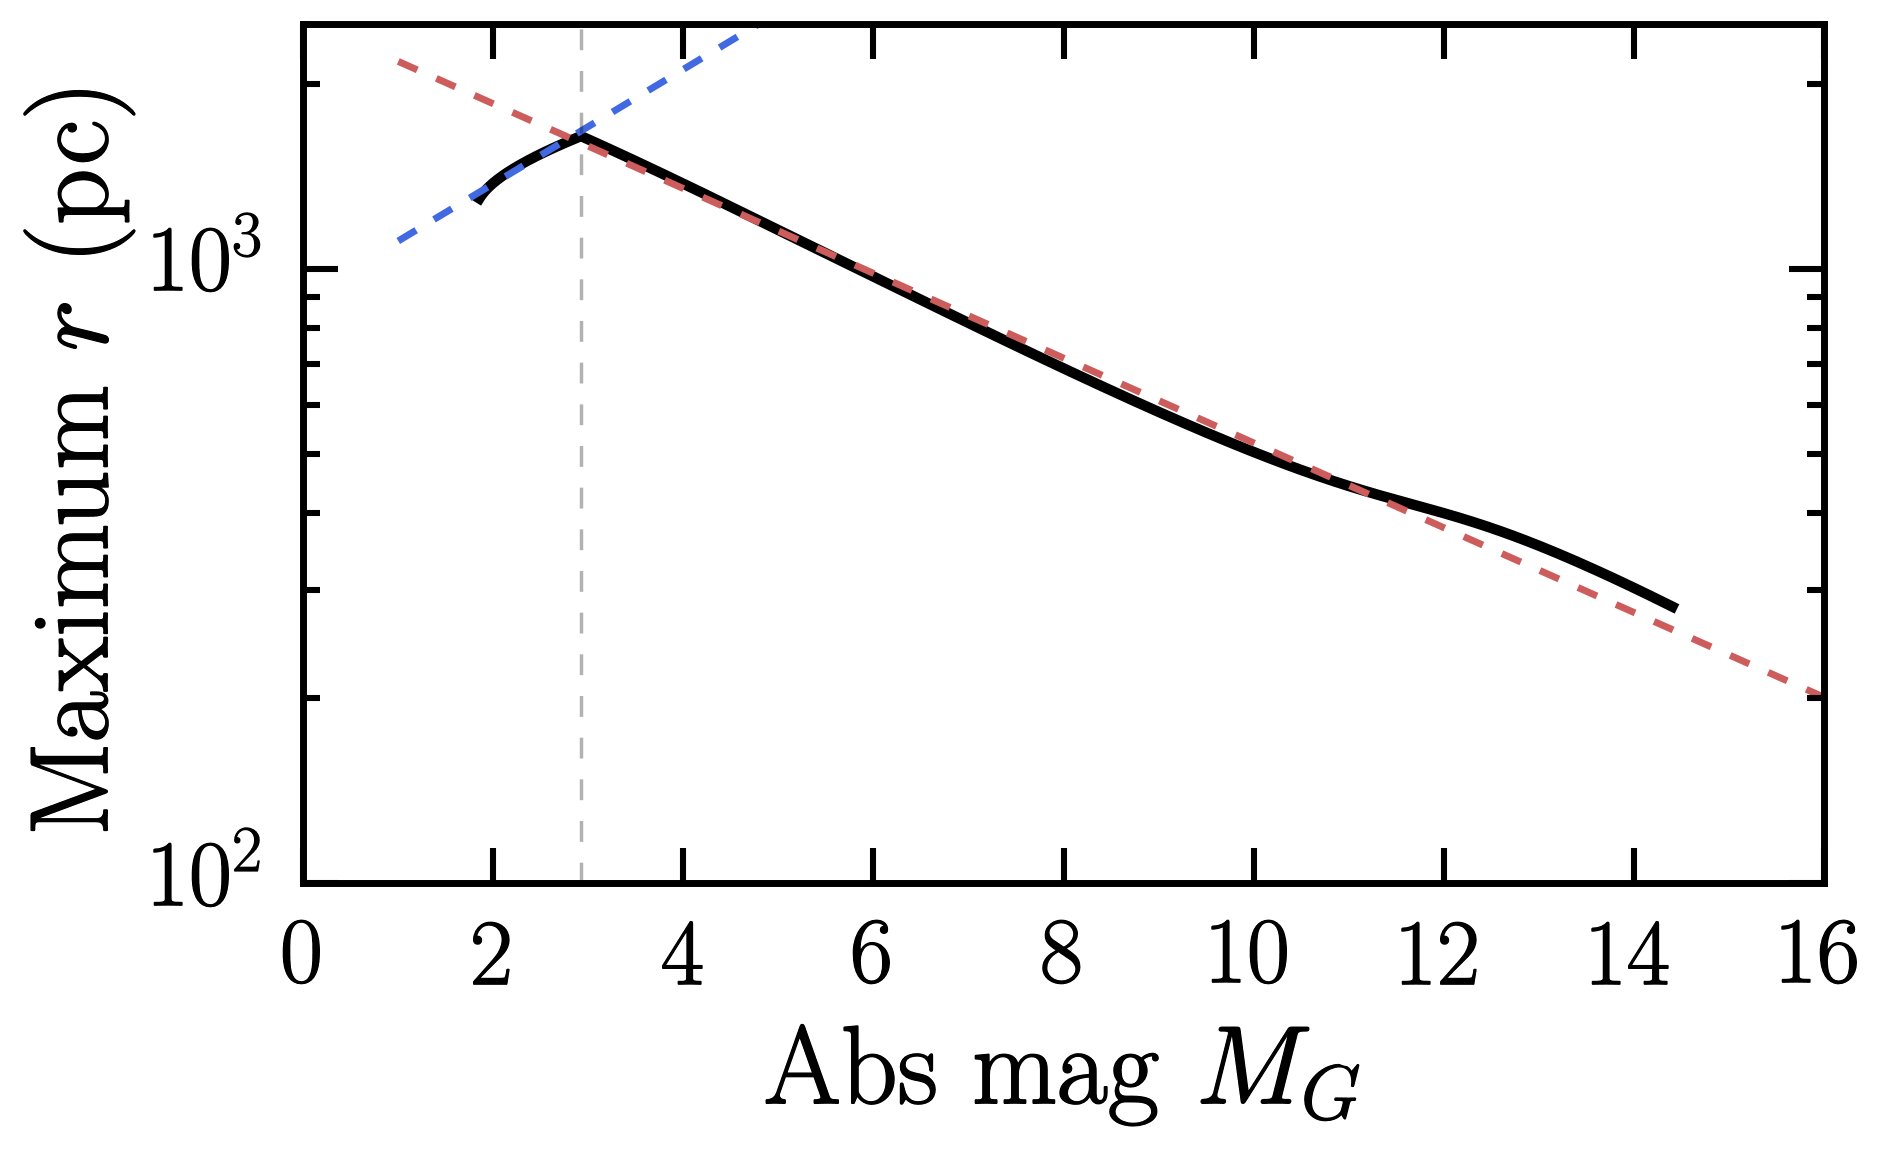

In [6]:
# make plot
fig, ax = plt.subplots(1, 1, figsize=(13.65*1.15/2, 11.8*1.15*0.95/3), dpi=250, facecolor='white')
mstarvals = np.linspace(0.1, 2.0, 1000)
absGmagvals = calc_absGmag(mstarvals)
a = 4.48555*mstarvals**(1./3.)
mplanet = 13.0
mratiovals = mplanet * 0.0009542 / mstarvals

# calculate rmax values
d_limits = []
for i in range(len(a)):
    d_limits.append(calc_limiting_distance(absGmagvals[i], mratiovals[i], a[i], N_sigma=0.5))
d_limits = np.array(d_limits)
ax.plot(absGmagvals, d_limits, '-', lw=3, c='k')
ax.set_xlabel(r'$\mathrm{Abs~mag}~M_G$', labelpad=7, fontsize=32)

# perform fit for left portion
x_grid = np.linspace(1.0, 16.0)
mask1 = (absGmagvals > 2.922)
coeffs1 = np.polyfit(absGmagvals[mask1], np.log10(d_limits[mask1]), deg=1)
print('coeffs1:', coeffs1)
y_grid1 = np.polyval(coeffs1, x_grid)

# perform fit for right portion
x_grid = np.linspace(1.0, 16.0)
mask2 = (absGmagvals < 2.922)
coeffs2 = np.polyfit(absGmagvals[mask2], np.log10(d_limits[mask2]), deg=1)
print('coeffs2:', coeffs2)
y_grid2 = np.polyval(coeffs2, x_grid)

# plot
ax.plot(x_grid, 10**y_grid1, c='indianred', lw=2, ls='--')
ax.plot(x_grid, 10**y_grid2, c='royalblue', lw=2, ls='--')
ax.axvline(x=2.922, c='k', ls='--', lw=1, alpha=0.3)
ax.set_ylabel(r'$\mathrm{Maximum}~r~\mathrm{(pc)}$', fontsize=32)
ax.set_yscale('log')
ax.set_ylim(1e2, 2500)
plt.show()

In [7]:
10**3.25450229, 10**2.81724719 # coefficients in pc

(1796.8105545865785, 656.5188347500074)

# Executing queries in small $r$ bins; $M_G$ > 2.8

In [8]:
# we will perform queries in r bins that contain comparable volumes
Vmin = (4/3)*np.pi*(0.1**3) # min volume
Vmax = (4/3)*np.pi*(1250**3) # max volume
volume_bins = np.linspace(Vmin, Vmax, 1000)
r_bins = (volume_bins*(3/4)/np.pi)**(1/3)
plx_bins = 1000/r_bins

In [ ]:
# execute queries and save to system (took ~4 hours on my laptop; the first few loops take the longest)
for i in tqdm(range(len(plx_bins)-1)):
    filename = 'data/Gaia_faint_star_properties/file' + str(i) + '.hkl'
    
    if not os.path.exists(filename):
        Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
        query = f"""
        SELECT
            gs.source_id, gs.RA, gs.Dec, gs.parallax, gs.pmra, gs.pmdec,
            gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.ruwe,
            aps.mass_flame
        FROM
            gaiadr3.gaia_source as gs
        JOIN
            gaiadr3.astrophysical_parameters AS aps
          ON gs.source_id = aps.source_id
        WHERE
            parallax BETWEEN {plx_bins[i+1]} AND {plx_bins[i]}
          AND phot_g_mean_mag < 19
          AND (phot_g_mean_mag - 10 + 5 * LOG10(parallax)) BETWEEN 2.80 AND 14.4049
          AND LOG10(1000/parallax) < -0.06894517*(phot_g_mean_mag - 10 + 5*LOG10(parallax)) + 3.40605655
        """

        # execute query
        job = Gaia.launch_job_async(query)
        results = job.get_results()
        print('parallax range:', plx_bins[i+1], '-', plx_bins[i])
        print(f"retrieved {len(results)} stars")

        # save results
        if len(results) > 0:
            source_ids = np.array(results['SOURCE_ID'])
            RAs = np.array(results['RA'])
            Decs = np.array(results['Dec'])
            parallaxes = np.array(results['parallax'])
            pmras = np.array(results['pmra'])
            pmdecs = np.array(results['pmdec'])
            phot_g_mean_mags = np.array(results['phot_g_mean_mag'])
            phot_bp_mean_mags = np.array(results['phot_bp_mean_mag'])
            phot_rp_mean_mags = np.array(results['phot_rp_mean_mag'])
            ruwes = np.array(results['ruwe'])
            stellar_masses = np.array(results['mass_flame'])

            hickle.dump([source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses], filename)

# Executing queries in small $r$ bins; $M_G$ < 2.8

In [9]:
# we will perform queries in r bins that contain comparable volumes
Vmin = (4/3)*np.pi*(0.1**3) # min volume
Vmax = (4/3)*np.pi*(1250**3) # max volume
volume_bins = np.linspace(Vmin, Vmax, 1000)
r_bins = (volume_bins*(3/4)/np.pi)**(1/3)
plx_bins = 1000/r_bins

In [ ]:
# execute queries and save to system (took ~2 hours on my laptop; the first few loops take the longest)
for i in tqdm(range(len(plx_bins)-1)):
    filename = 'data/Gaia_faint_star_properties/file' + str(i) + '.hkl'
    
    if not os.path.exists(filename):
        Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
        query = f"""
        SELECT
            gs.source_id, gs.RA, gs.Dec, gs.parallax, gs.pmra, gs.pmdec,
            gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.ruwe,
            aps.mass_flame
        FROM
            gaiadr3.gaia_source as gs
        JOIN
            gaiadr3.astrophysical_parameters AS aps
          ON gs.source_id = aps.source_id
        WHERE
            parallax BETWEEN {plx_bins[i+1]} AND {plx_bins[i]}
          AND phot_g_mean_mag < 19
          AND (phot_g_mean_mag - 10 + 5 * LOG10(parallax)) BETWEEN 1.8535 AND 2.80
          AND LOG10(1000/parallax) < 0.09306298*(phot_g_mean_mag - 10 + 5*LOG10(parallax)) + 2.95201128
        """

        # execute query
        job = Gaia.launch_job_async(query)
        results = job.get_results()
        print('parallax range:', plx_bins[i+1], '-', plx_bins[i])
        print(f"retrieved {len(results)} stars")

        # save results
        if len(results) > 0:
            source_ids = np.array(results['SOURCE_ID'])
            RAs = np.array(results['RA'])
            Decs = np.array(results['Dec'])
            parallaxes = np.array(results['parallax'])
            pmras = np.array(results['pmra'])
            pmdecs = np.array(results['pmdec'])
            phot_g_mean_mags = np.array(results['phot_g_mean_mag'])
            phot_bp_mean_mags = np.array(results['phot_bp_mean_mag'])
            phot_rp_mean_mags = np.array(results['phot_rp_mean_mag'])
            ruwes = np.array(results['ruwe'])
            stellar_masses = np.array(results['mass_flame'])

            hickle.dump([source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses], filename)

# Combining small files

In [ ]:
# load and record indices
successful_inds = []
for i in tqdm(range(1200)):
    try:
        data = hickle.load('Data/Gaia_faint_star_properties/file' + str(i) + '.hkl')
        source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses = data
        successful_inds.append(i)
    except Exception as e: # catch when the file doesn't exist
        print(i, e)

In [ ]:
# load and record indices
successful_inds = []
for i in tqdm(range(1200)):
    try:
        data = hickle.load('Data/Gaia_bright_star_properties/file' + str(i) + '.hkl')
        source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses = data
        successful_inds.append(i)
    except Exception as e: # catch when the file doesn't exist
        print(i, e)

In [ ]:
# create lists to store results
all_source_ids, all_RAs, all_Decs, all_parallaxes, all_pmras, all_pmdecs = [], [], [], [], [], []
all_phot_g_mean_mags, all_phot_bp_mean_mags, all_phot_rp_mean_mags = [], [], []
all_ruwes, all_stellar_masses = [], []

In [ ]:
# loop through files, collecting properties
for i in tqdm(range(1200)):
    try:
        data = hickle.load('Data/Gaia_faint_star_properties/file' + str(i) + '.hkl')
        source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses = data
        
        all_source_ids.extend(source_ids)
        all_RAs.extend(RAs)
        all_Decs.extend(Decs)
        all_parallaxes.extend(parallaxes)
        all_pmras.extend(pmras)
        all_pmdecs.extend(pmdecs)
        all_phot_g_mean_mags.extend(phot_g_mean_mags)
        all_phot_bp_mean_mags.extend(phot_bp_mean_mags)
        all_phot_rp_mean_mags.extend(phot_rp_mean_mags)
        all_ruwes.extend(ruwes)
        all_stellar_masses.extend(stellar_masses)
        
    except Exception as e: # catch when the file doesn't exist
        print(i, e)

In [ ]:
# loop through files, collecting properties
for i in tqdm(range(1200)):
    try:
        data = hickle.load('Data/Gaia_bright_star_properties/file' + str(i) + '.hkl')
        source_ids, RAs, Decs, parallaxes, pmras, pmdecs, phot_g_mean_mags, phot_bp_mean_mags, phot_rp_mean_mags, ruwes, stellar_masses = data
        
        all_source_ids.extend(source_ids)
        all_RAs.extend(RAs)
        all_Decs.extend(Decs)
        all_parallaxes.extend(parallaxes)
        all_pmras.extend(pmras)
        all_pmdecs.extend(pmdecs)
        all_phot_g_mean_mags.extend(phot_g_mean_mags)
        all_phot_bp_mean_mags.extend(phot_bp_mean_mags)
        all_phot_rp_mean_mags.extend(phot_rp_mean_mags)
        all_ruwes.extend(ruwes)
        all_stellar_masses.extend(stellar_masses)
        
    except Exception as e: # catch when the file doesn't exist
        print(i, e)

In [ ]:
# convert to numpy arrays
all_source_ids, all_RAs, all_Decs, all_parallaxes, all_pmras, all_pmdecs = np.array(all_source_ids), np.array(all_RAs), np.array(all_Decs), np.array(all_parallaxes), np.array(all_pmras), np.array(all_pmdecs)
all_phot_g_mean_mags, all_phot_bp_mean_mags, all_phot_rp_mean_mags = np.array(all_phot_g_mean_mags), np.array(all_phot_bp_mean_mags), np.array(all_phot_rp_mean_mags)
all_ruwes, all_stellar_masses = np.array(all_ruwes), np.array(all_stellar_masses)

In [ ]:
# save to pickle file (contains ~42 million stars, which is too big for GitHub)
with open("Data/Gaia_relevant_stars.pkl", "wb") as f:
    pickle.dump(all_source_ids, f)
    pickle.dump(all_RAs, f)
    pickle.dump(all_Decs, f)
    pickle.dump(all_parallaxes, f)
    pickle.dump(all_pmras, f)
    pickle.dump(all_pmdecs, f)
    pickle.dump(all_phot_g_mean_mags, f)
    pickle.dump(all_phot_bp_mean_mags, f)
    pickle.dump(all_phot_rp_mean_mags, f)
    pickle.dump(all_ruwes, f)
    pickle.dump(all_stellar_masses, f)

# Restricting to main sequence stars and assigning mases

In [ ]:
# load all relevant stars
f = open("Data/Gaia_relevant_stars.pkl", "rb")
source_ids = pickle.load(f)
RAs = pickle.load(f)
Decs = pickle.load(f)
parallaxes = pickle.load(f)
pmras = pickle.load(f)
pmdecs = pickle.load(f)
phot_g_mean_mags = pickle.load(f)
phot_bp_mean_mags = pickle.load(f)
phot_rp_mean_mags = pickle.load(f)
ruwes = pickle.load(f)
stellar_masses = pickle.load(f)
f.close()

In [ ]:
# calculate absolute magnitudes and Gaia colors
M_G = phot_g_mean_mags + 5.0 - 5.0*np.log10(1000/parallaxes)
G_BP_minus_G_RP = phot_bp_mean_mags - phot_rp_mean_mags

In [ ]:
# CMD diagram for relevant stars
plt.figure(figsize=(15,10), dpi=250, facecolor='white')
x_grid = np.linspace(-1, 6.0, 1000)
y_grid_upper = 2.9*x_grid+0.4
y_grid_lower = 2.9*x_grid+4.5
sc = plt.scatter(G_BP_minus_G_RP, M_G, s=0.1, c='k', edgecolor='none', alpha=0.05)
plt.plot(x_grid, y_grid_lower, c='r', lw=2.5)
plt.plot(x_grid, y_grid_upper, c='r', lw=2.5)
plt.gca().invert_yaxis()
plt.xlabel(r'$G_\mathrm{BP} - G_\mathrm{RP}$', fontsize=30)
plt.ylabel(r'$M_G$', fontsize=30)
plt.xlim([-1, 6])
plt.ylim([18, -3])
plt.show()

In [ ]:
# create main sequence mask
M_G_thresh_lower = 2.9*G_BP_minus_G_RP + 0.4
M_G_thresh_upper = 2.9*G_BP_minus_G_RP + 4.5
MS_mask = ((M_G_thresh_lower < M_G) & (M_G < M_G_thresh_upper))

In [ ]:
len(MS_mask), np.sum(MS_mask) # pretty small cut (~10% reduction)

In [ ]:
# apply mask
MS_source_ids = source_ids[MS_mask]
MS_RAs = RAs[MS_mask]
MS_Decs = Decs[MS_mask]
MS_parallaxes = parallaxes[MS_mask]
MS_pmras = pmras[MS_mask]
MS_pmdecs = pmdecs[MS_mask]
MS_phot_g_mean_mags = phot_g_mean_mags[MS_mask]
MS_phot_bp_mean_mags = phot_bp_mean_mags[MS_mask]
MS_phot_rp_mean_mags = phot_rp_mean_mags[MS_mask]
MS_ruwes = ruwes[MS_mask]
MS_stellar_masses = stellar_masses[MS_mask]
MS_MGs = MS_phot_g_mean_mags + 5.0 - 5.0*np.log10(1000/MS_parallaxes)

In [ ]:
# about half of relevant main sequence stars are missing masses
nan_mask = np.isnan(MS_stellar_masses)
np.sum(nan_mask)/len(MS_stellar_masses)

In [ ]:
# calculate masses with mass-mag relation
aps_masses = MS_stellar_masses[np.invert(nan_mask)]
aps_calc_masses = calc_mass(MS_MGs[np.invert(nan_mask)])
len(aps_masses), len(aps_calc_masses)

In [ ]:
# median relative error of about 7%
rel_errs = np.abs((aps_masses-aps_calc_masses)/aps_masses)
np.median(rel_errs)

In [ ]:
# fill in missing masses
MS_stellar_masses[nan_mask] = calc_mass(MS_MGs[nan_mask])
new_nan_mask = np.isnan(MS_stellar_masses)
np.sum(new_nan_mask)/len(MS_stellar_masses)

In [ ]:
# valley at ~0.5 M_sun is not real; its caused by the transition between Gaia masses and mass-mag masses
plt.figure(figsize=(10,6), dpi=250, facecolor='white')
plt.hist(MS_stellar_masses, range=(0.1, 2.0), bins=200, lw=0.0, color='royalblue', density=True)
plt.xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', fontsize=28)
plt.show()

In [ ]:
# scramble the order
rand_inds = np.random.choice(np.arange(len(MS_source_ids)), size=len(MS_source_ids), replace=False)
rand_inds

In [ ]:
# save catalog of relevant main-sequence stars
with open("Data/Gaia_relevant_stars_MS.pkl", "wb") as f:
    pickle.dump(MS_source_ids[rand_inds], f)
    pickle.dump(MS_RAs[rand_inds], f)
    pickle.dump(MS_Decs[rand_inds], f)
    pickle.dump(MS_parallaxes[rand_inds], f)
    pickle.dump(MS_pmras[rand_inds], f)
    pickle.dump(MS_pmdecs[rand_inds], f)
    pickle.dump(MS_phot_g_mean_mags[rand_inds], f)
    pickle.dump(MS_phot_bp_mean_mags[rand_inds], f)
    pickle.dump(MS_phot_rp_mean_mags[rand_inds], f)
    pickle.dump(MS_ruwes[rand_inds], f)
    pickle.dump(MS_stellar_masses[rand_inds], f)